In [14]:
import gensim.downloader as api
import spacy
import pandas as pd
import texthero as hero
from collections import Counter
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
from p_tqdm import p_map

pd.set_option('mode.chained_assignment', None)
plt.rcParams.update({'font.size': 15})

In [3]:
import sys
sys.path.append("..")
# os.environ["PYTHONPATH"] = "/home/czestoch/workspace/emoji-ambiguity/src"
from src.analysis.embedded import find_embedding

In [4]:
from tqdm.notebook import tqdm

In [6]:
AMBIGUITY_PATH = '/scratch/czestoch/ambiguity_dataset.csv.gz'

In [5]:
word_embeddings = api.load('glove-twitter-200')

In [6]:
twitter_space = {"word": [], "embedding": [], "space": "twitter"}
for word in word_embeddings.vocab.keys():
    twitter_space["word"].append(word)
    twitter_space["embedding"].append(word_embeddings.get_vector(word))
twitter_space = pd.DataFrame(twitter_space)
twitter_space.head()

,word,embedding,space
0,<user>,"[0.31553, 0.53765, 0.10177, 0.032553, 0.003798...",twitter
1,.,"[0.35132, 0.00056084, -0.21488, -0.04707, -0.1...",twitter
2,:,"[0.80767, 0.49786, 0.082696, -0.0079298, 0.082...",twitter
3,rt,"[0.55687, 0.63284, -0.15609, 0.26397, 0.28015,...",twitter
4,",","[0.3927, -0.084181, -0.6075, 0.3231, -0.35919,...",twitter


In [7]:
from p_tqdm import p_map

In [ ]:
######

In [7]:
emojis = pd.read_csv(AMBIGUITY_PATH, encoding='utf-8')
print("Choosing subset of words...")
vocabularies = emojis[["emoji", "word"]] \
    .groupby("emoji").word \
    .apply(list).apply(Counter) \
    .reset_index() \
    .rename({"word": "vocabulary"}, axis=1).set_index("emoji")
ambiguity_vocab = {st for row in vocabularies.vocabulary for st in row}

Choosing subset of words...


In [8]:
emojis = pd.read_csv(AMBIGUITY_PATH, encoding='utf-8')
print("Choosing subset of words...")
vocabularies = emojis[["emoji", "word"]] \
    .groupby("emoji").word \
    .apply(list).apply(Counter) \
    .reset_index() \
    .rename({"word": "vocabulary"}, axis=1).set_index("emoji")
ambiguity_vocab = {st for row in vocabularies.vocabulary for st in row}
print("Computing embeddings...")
tokenizer = spacy.load("en_core_web_sm")
emoji_subspace = {"word": [], "embedding": [], "space": "emoji"}
for emoji_description in ambiguity_vocab:
    tokens = {token.text for token in tokenizer(emoji_description)}
    vec = find_embedding(tokens, word_embeddings)
    if vec is not None:
        emoji_subspace["word"].append(emoji_description)
        emoji_subspace["embedding"].append(vec)
emoji_subspace = pd.DataFrame(emoji_subspace)
emoji_subspace.head()

Choosing subset of words...
Computing embeddings...


,word,embedding,space
0,gold heart,"[0.18928699, -0.2627045, -0.27628, -0.04256500...",emoji
1,attention,"[-0.13379, 0.70343, -0.48413, 0.10628, 0.1104,...",emoji
2,amoeba,"[-0.74858, 0.13429, 0.17236, 0.07577, 0.6348, ...",emoji
3,bat,"[0.80892, -0.10589, -0.77399, -0.50479, 0.5348...",emoji
4,euro,"[0.030641, 0.0068182, 0.35764, -0.044425, -0.5...",emoji


In [9]:
del word_embeddings

In [10]:
emoji_subspace['pca'] = hero.pca(emoji_subspace['embedding'])

In [19]:
from settings import EMOJI_CATEGORIZED

with open(EMOJI_CATEGORIZED, "rb") as f:
    emojis_categorized = pickle.load(f)
    
ambiguity = pd.read_csv("/scratch/czestoch/ambiguity_dataset.csv.gz")
ambiguity = ambiguity[["emoji", "word"]]

categorized = {c:set(e) for c,e in emojis_categorized.items()}
emojis = emojis[["emoji", "word"]]

emoji_subspace.word = emoji_subspace.word.astype(str)
emojis.word = ambiguity.word.astype(str)
emojis = emojis.drop_duplicates("word")

emoji_subspace1 = pd.merge(emoji_subspace, emojis, how='left', left_on='word', right_on='word')
emoji_subspace1["category"] = "twitter"

# emoji_space = whole_space1[whole_space1.space == 'emoji']

def find_categories(df):
    indices = []
    for idx, row in tqdm(df.iterrows()):
        for category in categorized:
            if row.emoji in categorized[category]:
                indices.append((idx, category))
    return indices

n_cores = 8
df_split = np.array_split(emoji_subspace1, n_cores)
out = p_map(find_categories, df_split, num_cpus=n_cores)

from itertools import chain

to_set = list(chain.from_iterable(out))

unzipped = list(zip(*to_set))
indices = unzipped[0]
categories = unzipped[1]

emoji_subspace1.loc[indices, "category"] = categories

  0%|          | 0/8 [00:00<?, ?it/s]

In [23]:
emoji_subspace1[['pca_x','pca_y']] = pd.DataFrame(emoji_subspace1.pca.tolist(), index=emoji_subspace1.index)

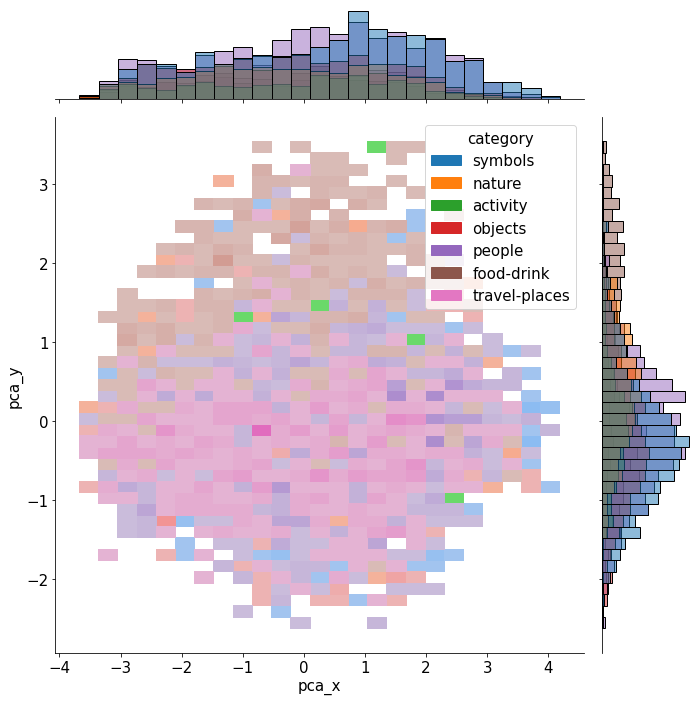

In [26]:
df = emoji_subspace1[emoji_subspace1.category != 'flags']
sns.jointplot(data=df, x='pca_x', y='pca_y', hue='category', kind='hist', height=10);

In [10]:
whole_space = pd.concat((twitter_space, emoji_subspace))

In [11]:
whole_space['pca'] = hero.pca(whole_space['embedding'])

In [12]:
whole_space[['pca_x','pca_y']] = pd.DataFrame(whole_space.pca.tolist(), index=whole_space.index)

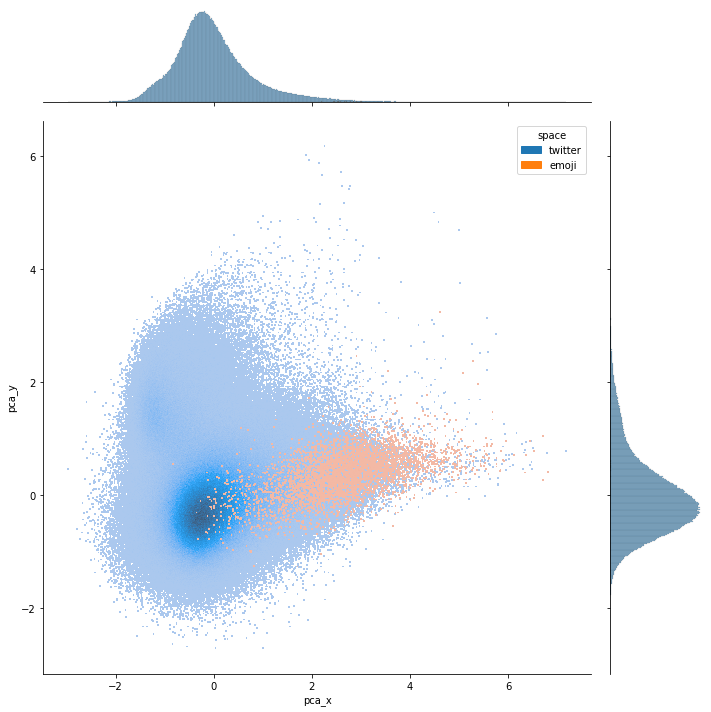

In [13]:
sns.jointplot(data=whole_space, x='pca_x', y='pca_y', hue='space', kind='hist', height=10);

In [12]:
import pickle

In [39]:
from settings import EMOJI_CATEGORIZED

with open(EMOJI_CATEGORIZED, "rb") as f:
    emojis_categorized = pickle.load(f)
    
ambiguity = pd.read_csv("/scratch/czestoch/ambiguity_dataset.csv.gz")
ambiguity = ambiguity[["emoji", "word"]]

categorized = {c:set(e) for c,e in emojis_categorized.items()}
emojis = emojis[["emoji", "word"]]

whole_space.word = whole_space.word.astype(str)
emojis.word = ambiguity.word.astype(str)
emojis = emojis.drop_duplicates("word")

whole_space1 = pd.merge(whole_space, emojis, how='left', left_on='word', right_on='word')
whole_space1["category"] = "twitter"

emoji_space = whole_space1[whole_space1.space == 'emoji']

def find_categories(df):
    indices = []
    for idx, row in tqdm(df.iterrows()):
        for category in categorized:
            if row.emoji in categorized[category]:
                indices.append((idx, category))
    return indices

n_cores = 8
df_split = np.array_split(emoji_space, n_cores)
out = p_map(find_categories, df_split, num_cpus=n_cores)

from itertools import chain

to_set = list(chain.from_iterable(out))

unzipped = list(zip(*to_set))
indices = unzipped[0]
categories = unzipped[1]

whole_space1.loc[indices, "category"] = categories

  0%|          | 0/8 [00:00<?, ?it/s]

In [16]:
whole_space1[whole_space1.space == 'twitter'].category.unique()

array(['twitter'], dtype=object)

In [23]:
len(whole_space)

1198047

In [42]:
whole_space1.head()

,word,embedding,space,pca,pca_x,pca_y,emoji,category
0,<user>,"[0.31553, 0.53765, 0.10177, 0.032553, 0.003798...",twitter,"[4.727020601566444, 1.8354365643906132]",4.727021,1.835437,NaN,twitter
1,.,"[0.35132, 0.00056084, -0.21488, -0.04707, -0.1...",twitter,"[4.801126705595327, 0.6620096216479852]",4.801127,0.662010,NaN,twitter
2,:,"[0.80767, 0.49786, 0.082696, -0.0079298, 0.082...",twitter,"[4.918915516164837, 1.624813562081168]",4.918916,1.624814,NaN,twitter
3,rt,"[0.55687, 0.63284, -0.15609, 0.26397, 0.28015,...",twitter,"[4.698771715058808, 1.7953444337913447]",4.698772,1.795344,NaN,twitter
4,",","[0.3927, -0.084181, -0.6075, 0.3231, -0.35919,...",twitter,"[5.058581568730351, 0.9562422778430317]",5.058582,0.956242,NaN,twitter


In [57]:
whole_space1.category.unique()

array(['twitter', 'people', 'symbols', 'travel-places', 'objects',
       'activity', 'nature', 'food-drink', 'flags'], dtype=object)

In [58]:
categories = ['people', 'symbols', 'travel-places', 'objects',
               'activity', 'nature', 'food-drink']

In [60]:
import matplotlib.pyplot as plt

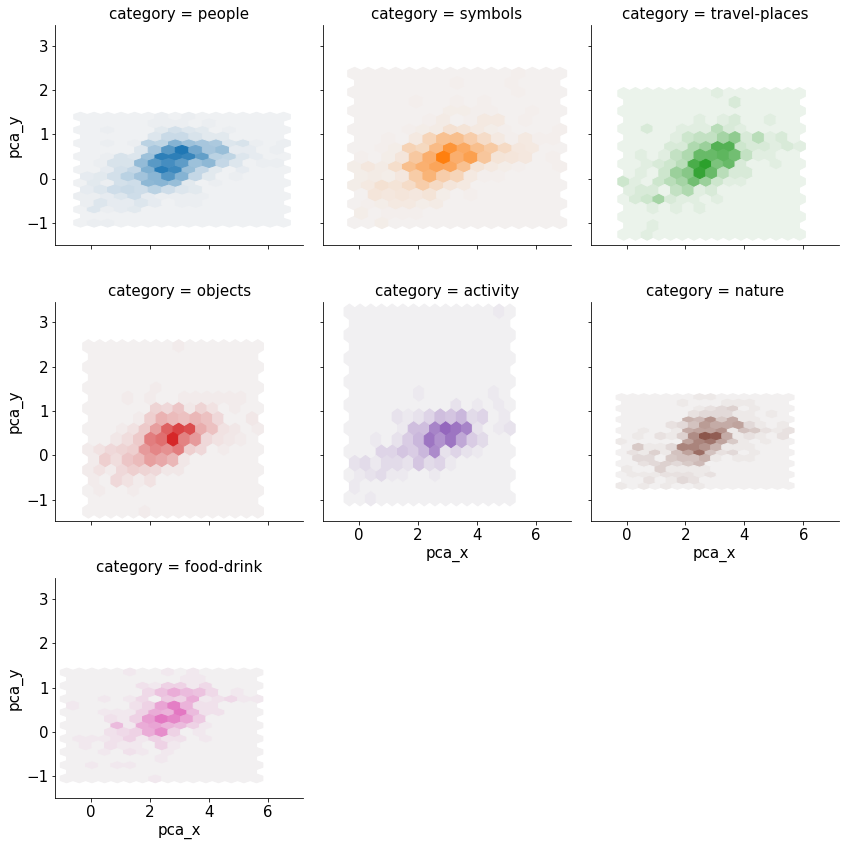

In [81]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

# with sns.axes_style("dark"):
df = whole_space1[(whole_space1.space =='emoji') & (whole_space1.category != 'flags')]
g = sns.FacetGrid(df, hue="category", col="category", col_wrap=3, height=4)
g.map(hexbin, "pca_x", "pca_y");

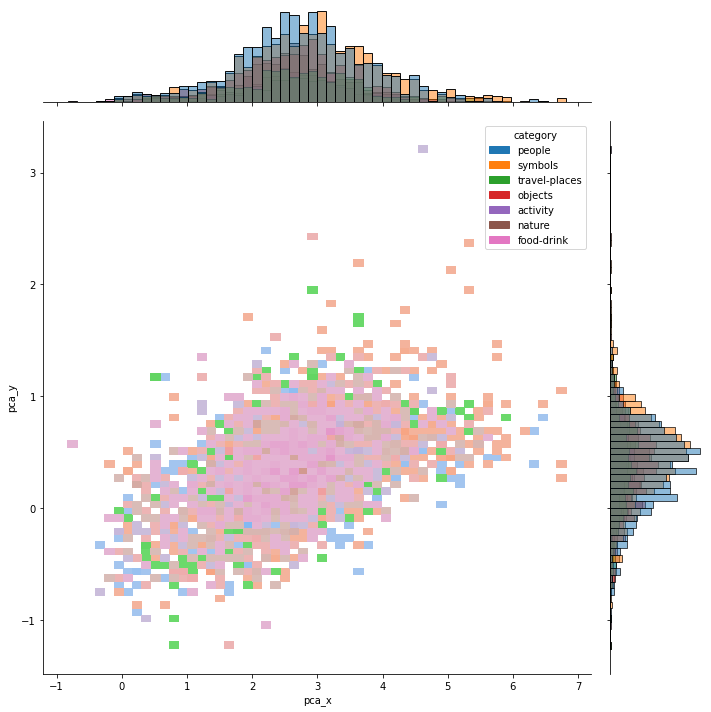

In [70]:
df = whole_space1[(whole_space1.space =='emoji') & (whole_space1.category != 'flags')]
sns.jointplot(data=df, x='pca_x', y='pca_y', hue='category', kind='hist', height=10);

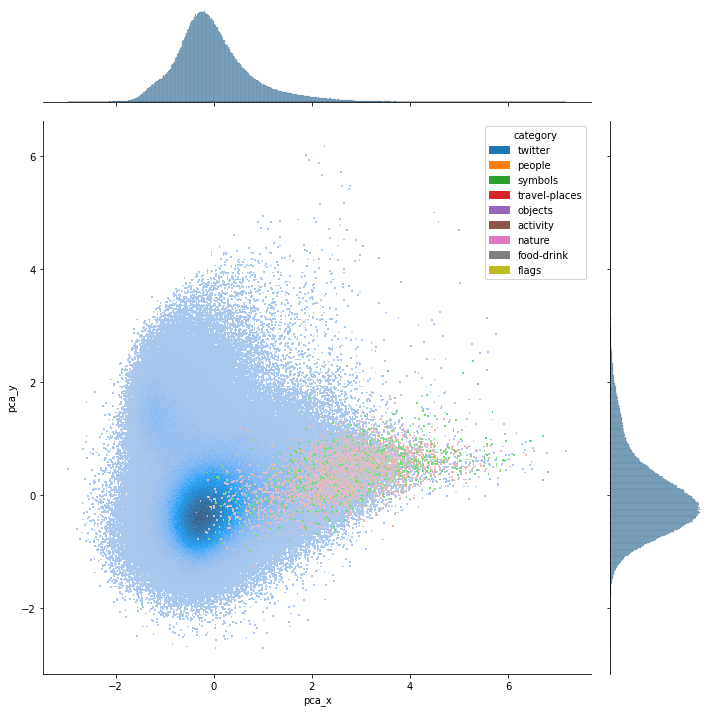

In [43]:
sns.jointplot(data=whole_space1, x='pca_x', y='pca_y', hue='category', kind='hist', height=10);

## t-SNE

In [1]:
import pickle

In [2]:
with open("/scratch/czestoch/tsne.pkl", "rb") as f:
    whole_space = pickle.load(f)

In [3]:
whole_space.head()

,word,embedding,space,tsne_x,tsne_y
0,<user>,"[0.31553, 0.53765, 0.10177, 0.032553, 0.003798...",twitter,5.798072,1.969729
1,.,"[0.35132, 0.00056084, -0.21488, -0.04707, -0.1...",twitter,1.230961,6.798352
2,:,"[0.80767, 0.49786, 0.082696, -0.0079298, 0.082...",twitter,3.518226,5.347583
3,rt,"[0.55687, 0.63284, -0.15609, 0.26397, 0.28015,...",twitter,5.814109,1.982771
4,",","[0.3927, -0.084181, -0.6075, 0.3231, -0.35919,...",twitter,1.164581,6.879390


In [7]:
len(whole_space)

1198047

In [5]:
import seaborn as sns

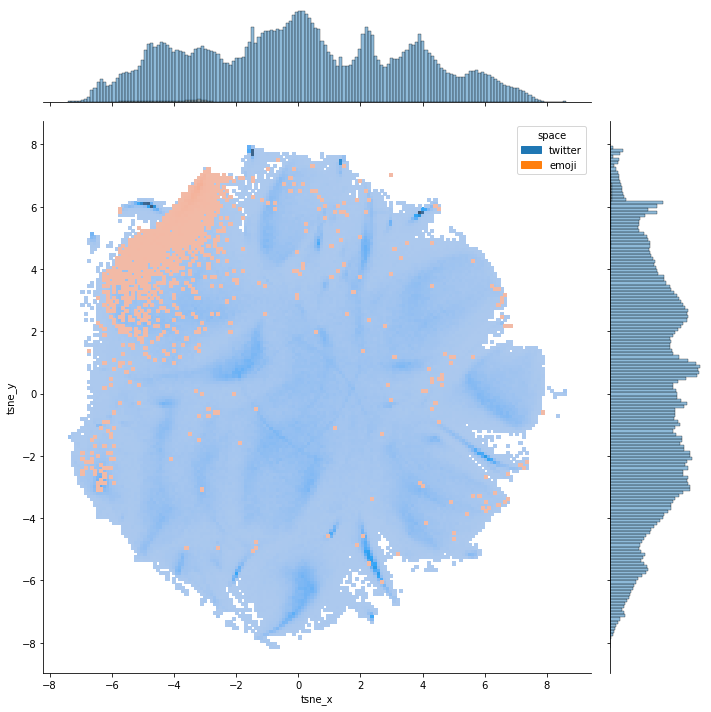

In [6]:
sns.jointplot(data=whole_space, x='tsne_x', y='tsne_y', hue='space', kind='hist', height=10);

In [13]:
whole_space = whole_space[['word', 'space', 'tsne_x', 'tsne_y']]

In [56]:
from settings import EMOJI_CATEGORIZED

with open(EMOJI_CATEGORIZED, "rb") as f:
    emojis_categorized = pickle.load(f)

In [57]:
categorized = {c:set(e) for c,e in emojis_categorized.items()}

In [17]:
import pandas as pd

In [19]:
ambiguity = pd.read_csv("/scratch/czestoch/ambiguity_dataset.csv.gz")

In [23]:
ambiguity = ambiguity[["emoji", "word"]]
ambiguity.head()

,emoji,word
0,#️⃣,ash
1,#️⃣,hashtag
2,#️⃣,hashtag
3,#️⃣,pound
4,#️⃣,pound


In [45]:
from settings import EMOJI_CATEGORIZED

with open(EMOJI_CATEGORIZED, "rb") as f:
    emojis_categorized = pickle.load(f)
    
ambiguity = pd.read_csv("/scratch/czestoch/ambiguity_dataset.csv.gz")
ambiguity = ambiguity[["emoji", "word"]]

categorized = {c:set(e) for c,e in emojis_categorized.items()}
emojis = emojis[["emoji", "word"]]

whole_space.word = whole_space.word.astype(str)
emojis.word = ambiguity.word.astype(str)
emojis = emojis.drop_duplicates("word")

whole_space1 = pd.merge(whole_space, emojis, how='left', left_on='word', right_on='word')
whole_space1["category"] = "twitter"

emoji_space = whole_space1[whole_space1.space == 'emoji']

def find_categories(df):
    indices = []
    for idx, row in tqdm(df.iterrows()):
        for category in categorized:
            if row.emoji in categorized[category]:
                indices.append((idx, category))
    return indices

n_cores = 8
df_split = np.array_split(emoji_space, n_cores)
out = p_map(find_categories, df_split, num_cpus=n_cores)

from itertools import chain

to_set = list(chain.from_iterable(out))

unzipped = list(zip(*to_set))
indices = unzipped[0]
categories = unzipped[1]

whole_space1.loc[indices, "category"] = categories

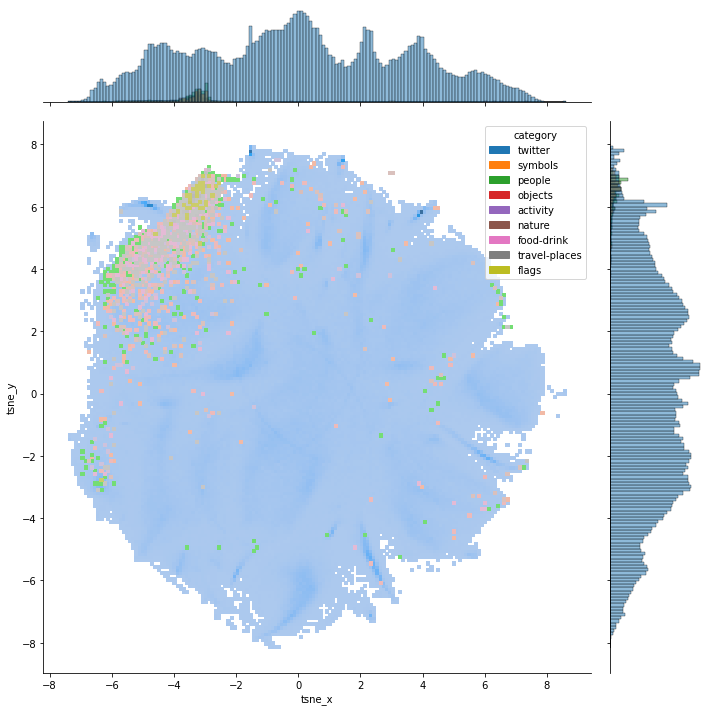

In [122]:
sns.jointplot(data=whole_space, x='tsne_x', y='tsne_y', hue='category', kind='hist', height=10);